In [1]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.utils import image_dataset_from_directory as imdd
from tensorflow.keras import layers, Sequential

2023-04-17 14:47:26.359974: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 14:47:26.564958: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-17 14:47:27.294285: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/dell/miniconda3/envs/tf/lib/:/home/dell/miniconda3/envs/tf/lib/python3.8/site-packages/tensorrt/
2023-04-17 14:47:27.294389: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load d

In [2]:
class_name = ['COVID','Lung_Opacity','Normal','Viral Pneumonia']

In [3]:
ds_train = imdd(
    '/home/dell/ML/Lung/directory',
    labels = 'inferred',
    label_mode = 'categorical',
    color_mode = 'grayscale',
    image_size = (64,64),
    shuffle = True,
    seed = 111,
    validation_split = 0.2,
    subset = 'training'
)
ds_val = imdd(
    '/home/dell/ML/Lung/directory',
    labels = 'inferred',
    label_mode = 'categorical',
    color_mode = 'grayscale',
    image_size = (64,64),
    shuffle = True,
    seed = 111,
    validation_split = 0.2,
    subset = 'validation'
)

Found 21165 files belonging to 4 classes.
Using 16932 files for training.


2023-04-17 14:47:29.105788: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-17 14:47:29.110434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-17 14:47:29.110698: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-17 14:47:29.111231: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Found 21165 files belonging to 4 classes.
Using 4233 files for validation.


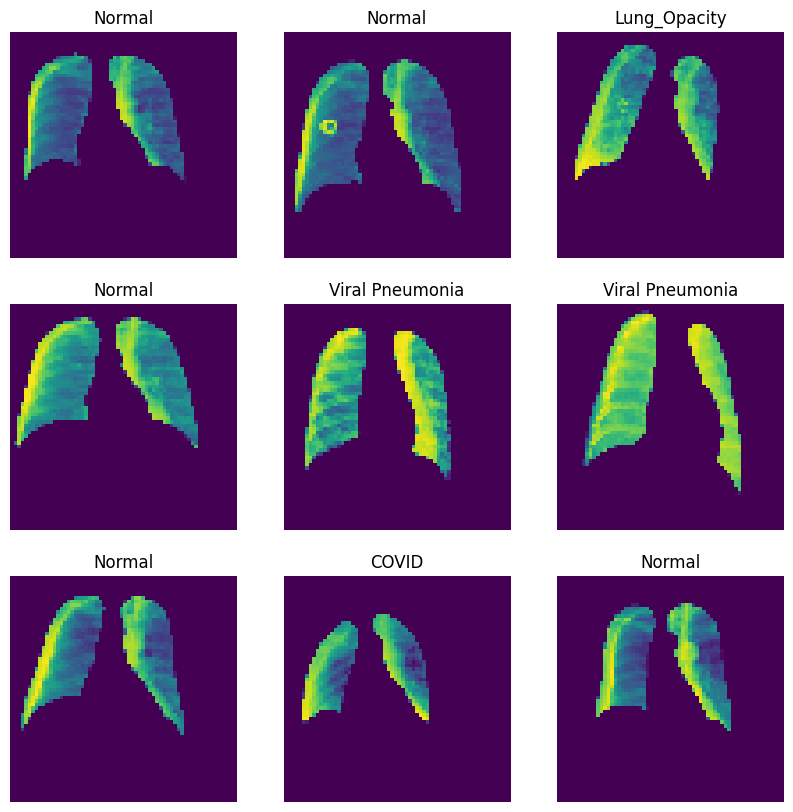

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_name[np.argmax(labels[i])])
    plt.axis("off")


In [7]:
model = Sequential(
    [
        layers.Rescaling(1./255., input_shape = (64,64,1)),
        layers.Conv2D(8, (5,5), padding = 'same', activation = 'relu'),
        layers.Conv2D(16, (5,5), padding = 'same', activation = 'relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Conv2D(64, (3,3), activation = 'relu'),
        layers.Conv2D(128, (3,3), activation = 'relu'),
        layers.MaxPooling2D(),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(4, activation = 'softmax', name = 'output')
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 8)         208       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        3216      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 16)        0

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

ds_train = ds_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
ds_val = ds_val.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy']
)

In [10]:
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=3)

In [11]:
print(ds_train)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>


In [12]:
with tf.device('CPU'):
    model.fit(
        ds_train,
        validation_data = ds_val,
        epochs = 32,
    )

Epoch 1/32


2023-04-17 14:48:36.937427: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 396 of 1000
2023-04-17 14:48:40.019620: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


530/530 [==============================] - 119s 199ms/step - loss: 1.0584 - accuracy: 0.6583 - val_loss: 1.8075 - val_accuracy: 0.3829
Epoch 2/32
530/530 [==============================] - 107s 201ms/step - loss: 0.7263 - accuracy: 0.7284 - val_loss: 0.9282 - val_accuracy: 0.6397
Epoch 3/32
530/530 [==============================] - 114s 214ms/step - loss: 0.6424 - accuracy: 0.7504 - val_loss: 0.7931 - val_accuracy: 0.7134
Epoch 4/32
530/530 [==============================] - 109s 206ms/step - loss: 0.6045 - accuracy: 0.7627 - val_loss: 0.8924 - val_accuracy: 0.7300
Epoch 5/32
530/530 [==============================] - 111s 210ms/step - loss: 0.5892 - accuracy: 0.7723 - val_loss: 0.6802 - val_accuracy: 0.7465
Epoch 6/32
530/530 [==============================] - 116s 219ms/step - loss: 0.5437 - accuracy: 0.7895 - val_loss: 0.5930 - val_accuracy: 0.7775
Epoch 7/32
530/530 [==============================] - 121s 228ms/step - loss: 0.5101 - accuracy: 0.8021 - val_loss: 0.5579 - val_accura

In [13]:
model.save('class_model_93_80.h5')

In [22]:
model = Sequential(
    [
        layers.Rescaling(1./255., input_shape = (64,64,1)),
        layers.Conv2D(8, (5,5), padding = 'same', activation = 'relu'),
        layers.Conv2D(16, (5,5), padding = 'same', activation = 'relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Conv2D(32, (3,3), activation = 'relu'),
        layers.Conv2D(64, (3,3), activation = 'relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Conv2D(128, (3,3), activation = 'relu'),
        layers.Conv2D(128*2, (3,3), activation = 'relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(4, activation = 'softmax', name = 'output')
    ]
)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 64, 64, 1)         0         
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 8)         208       
                                                                 
 conv2d_17 (Conv2D)          (None, 64, 64, 16)        3216      
                                                                 
 batch_normalization_6 (Batc  (None, 64, 64, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 30, 30, 32)       

In [23]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy']
)

In [24]:
with tf.device('CPU'):
    model.fit(
        ds_train,
        validation_data = ds_val,
        epochs = 32,
        shuffle = True,
    )

Epoch 1/32
530/530 [==============================] - 64s 120ms/step - loss: 0.7818 - accuracy: 0.6912 - val_loss: 1.1007 - val_accuracy: 0.6974
Epoch 2/32
530/530 [==============================] - 63s 119ms/step - loss: 0.6041 - accuracy: 0.7659 - val_loss: 0.6997 - val_accuracy: 0.7392
Epoch 3/32
530/530 [==============================] - 63s 119ms/step - loss: 0.5320 - accuracy: 0.7968 - val_loss: 0.6421 - val_accuracy: 0.7501
Epoch 4/32
530/530 [==============================] - 63s 120ms/step - loss: 0.4789 - accuracy: 0.8172 - val_loss: 0.5038 - val_accuracy: 0.8060
Epoch 5/32
530/530 [==============================] - 63s 119ms/step - loss: 0.4370 - accuracy: 0.8305 - val_loss: 0.5898 - val_accuracy: 0.7692
Epoch 6/32
530/530 [==============================] - 63s 120ms/step - loss: 0.3982 - accuracy: 0.8491 - val_loss: 0.4908 - val_accuracy: 0.8089
Epoch 7/32
530/530 [==============================] - 63s 120ms/step - loss: 0.3703 - accuracy: 0.8590 - val_loss: 0.4525 - val_ac

In [ ]:
model.save('class_model_idk.h5')